In [15]:
#Importation
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [2]:
dataset=pd.read_csv("C:\\Users\\karel\\OneDrive\\Bureau\\ISEP1\\AUTRES ISEP1\\ML\\Projets\\Zindi_Fraude\\training.csv")
df=dataset.copy()
df=df.drop(['CurrencyCode', 'CountryCode'],axis=1)

#création de variables temporelles
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])
df['DayOfWeek'] = df['TransactionStartTime'].dt.dayofweek
df['WeekOfYear'] = df['TransactionStartTime'].dt.isocalendar().week
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6])
df['Month'] = df['TransactionStartTime'].dt.month
df['Day'] = df['TransactionStartTime'].dt.day
df['Hour'] = df['TransactionStartTime'].dt.hour
df['Crénaux_horaire'] = pd.cut(df['Hour'], 
                       bins=[0, 6, 12, 18, 24], 
                       labels=['Nuit', 'Matin', 'Après-midi', 'Soir'])

#on crée des sous datasets des différentes catégories de la target
fraude=df[df['FraudResult']==1]
non_fraude=df[df['FraudResult']==0]

#créer des datasets selon les groupes des features
identifiants=df[['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId']]
info_produits_et_services=df[['ProviderId', 'ProductId',
       'ProductCategory', 'ChannelId']]
valeurs_financières=df[['Amount', 'Value']]
startégie=df['PricingStrategy']
heure=df['Hour']
jour_sem=df['DayOfWeek']
jour_mois=df['Day']
Crénaux_horaire=df['Crénaux_horaire']
semaine_année=df['WeekOfYear']
mois=df['Month']


In [18]:
X=df.drop('FraudResult',axis=1)
y=df['FraudResult']
x_train, x_test, y_train, y_test=train_test_split(X,y, test_size=0.15,stratify=y)

In [10]:
y_test.value_counts()

FraudResult
0    14321
1       29
Name: count, dtype: int64

In [19]:
from sklearn.preprocessing import TargetEncoder

num = make_column_selector(dtype_include='number')
cat = make_column_selector(dtype_exclude='number')
trans_num = make_pipeline(RobustScaler())
trans_cat = make_pipeline(TargetEncoder(), RobustScaler())
transformer = make_column_transformer((trans_num, num), (trans_cat, cat))
x_train_trans = transformer.fit_transform(x_train, y_train)  # Attention: y_train nécessaire
x_test_trans = transformer.transform(x_test)  # Utilisez transform, pas fit_transform

# Evaluation 

In [25]:
def evaluation(model,X_train=x_train_trans,X_test=x_test_trans):
    
    model.fit(x_train_trans, y_train)
    ypred = model.predict(x_test_trans)
    
    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))
    cv=StratifiedKFold(4)
    N, train_score, val_score = learning_curve(model, x_train_trans, y_train,
                                              cv=cv, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    plt.figure(figsize=(10, 6))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.xlabel('Taille de l\'échantillon')
    plt.ylabel('Score')
    plt.title('Courbes d\'apprentissage')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Figure 2 - Matrice de confusion
    


## Fonction for training grids

In [26]:
def train_grid(search,X_train=x_train_trans,X_test=x_test_trans):
    search.fit(X_train, y_train)
    print(search.best_params_)
    y_pred = search.predict(X_test)
    evaluation(search.best_estimator_,X_train,X_test)

First model

In [13]:
preprocessor = make_pipeline(PolynomialFeatures(2, include_bias=False), SelectKBest(f_classif, k=10))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\karel\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
30 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\karel\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\karel\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\karel\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 469, in fit
    Xt = self._fit(X, y, rou

{'selectkbest__k': 15, 'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__max_features': 0.5, 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__bootstrap': False, 'polynomialfeatures__interaction_only': False, 'polynomialfeatures__degree': 1}


C:\Users\karel\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\karel\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[[17184     1]
 [    6    29]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17185
           1       0.97      0.83      0.89        35

    accuracy                           1.00     17220
   macro avg       0.98      0.91      0.95     17220
weighted avg       1.00      1.00      1.00     17220



C:\Users\karel\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\karel\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\karel\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\karel\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\karel\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\

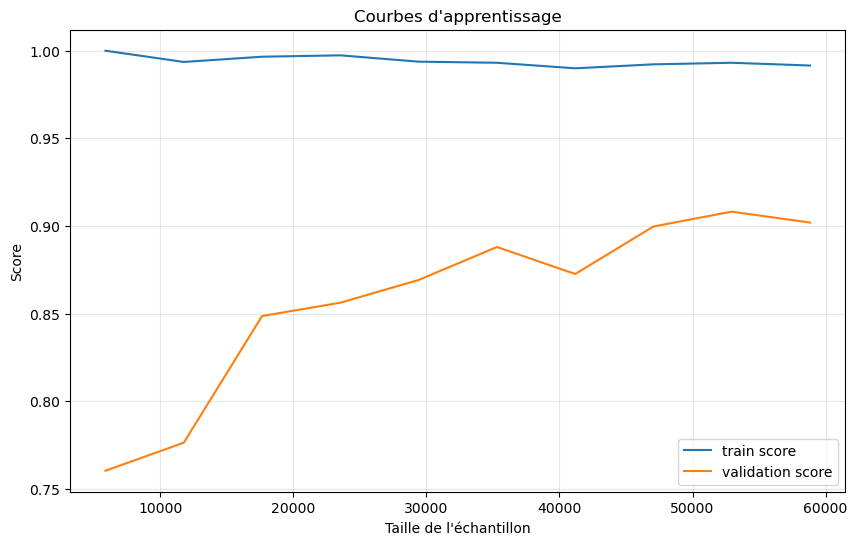

CPU times: total: 7min 29s
Wall time: 52min 35s


In [7]:
%%time
pipe = make_pipeline(
    PolynomialFeatures(),
    SelectKBest(f_classif),
    RandomForestClassifier(random_state=0)
)

param_dist = {
    "polynomialfeatures__degree": [1, 2, 3],
    "polynomialfeatures__interaction_only": [False, True],
    "selectkbest__k": [5, 10, 12, 13, 15, 20, "None"],
    "randomforestclassifier__n_estimators": [100, 200, 300],
    "randomforestclassifier__max_depth": [None, 5, 10, 20],
    "randomforestclassifier__min_samples_split": [2, 5, 10],
    "randomforestclassifier__min_samples_leaf": [1, 2, 4, 8],
    "randomforestclassifier__max_features": ["sqrt", "log2", 0.5],
    "randomforestclassifier__bootstrap": [True, False]
}

search = RandomizedSearchCV(
    pipe, param_distributions=param_dist,
    n_iter=50, cv=5, n_jobs=2, random_state=0, verbose=2
)
search.fit(x_train_trans, y_train)

print(search.best_params_)

y_pred = search.predict(x_test_trans)
evaluation(search.best_estimator_)

## AdaBoost 

C:\Users\karel\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\karel\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\karel\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\karel\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\kar

{'pipeline__selectkbest__k': 15, 'pipeline__polynomialfeatures__interaction_only': True, 'pipeline__polynomialfeatures__degree': 1, 'adaboostclassifier__n_estimators': 200, 'adaboostclassifier__learning_rate': 0.05, 'adaboostclassifier__algorithm': 'SAMME.R'}


C:\Users\karel\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[[14320     1]
 [    1    28]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14321
           1       0.97      0.97      0.97        29

    accuracy                           1.00     14350
   macro avg       0.98      0.98      0.98     14350
weighted avg       1.00      1.00      1.00     14350



C:\Users\karel\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\karel\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\karel\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\karel\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\kar

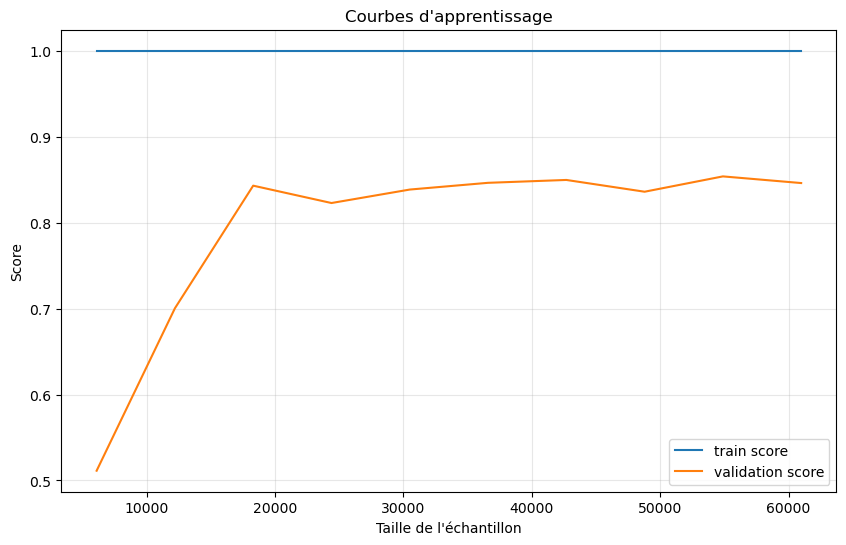

{'pipeline__selectkbest__k': 15, 'pipeline__polynomialfeatures__interaction_only': True, 'pipeline__polynomialfeatures__degree': 1, 'adaboostclassifier__n_estimators': 200, 'adaboostclassifier__learning_rate': 0.05, 'adaboostclassifier__algorithm': 'SAMME.R'}
CPU times: total: 2h 21min 21s
Wall time: 2h 26min 3s


In [20]:
%%time
param_distributions = {
    # PolynomialFeatures - Réduire la complexité
    'pipeline__polynomialfeatures__degree': [1, 2],  # Supprimer degree=3
    'pipeline__polynomialfeatures__interaction_only': [True],  # Forcer les interactions seulement
    
    # SelectKBest - Moins de features
    'pipeline__selectkbest__k': [10, 15,17,18,20],  # Réduire le nombre max de features
    
    # AdaBoost - Paramètres anti-overfitting
    'adaboostclassifier__n_estimators': [100, 150,200,250],  # Moins d'estimateurs
    'adaboostclassifier__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],  # Learning rates plus faibles
    'adaboostclassifier__algorithm': ['SAMME.R']  # SAMME.R généralement moins prone à l'overfitting
}
AdaBoost = make_pipeline(preprocessor, AdaBoostClassifier(
    estimator=DecisionTreeClassifier(),  # Estimateur explicite
    random_state=0
))
grid_ada = RandomizedSearchCV(AdaBoost, param_distributions, scoring='recall', cv=5, n_iter=50,random_state=0)
train_grid(grid_ada)
print(grid_ada.best_params_)

## SVM 

C:\Users\karel\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'svc__kernel': 'rbf', 'svc__gamma': 0.1, 'svc__degree': 2, 'svc__C': 1}
[[14319     2]
 [    5    24]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14321
           1       0.92      0.83      0.87        29

    accuracy                           1.00     14350
   macro avg       0.96      0.91      0.94     14350
weighted avg       1.00      1.00      1.00     14350



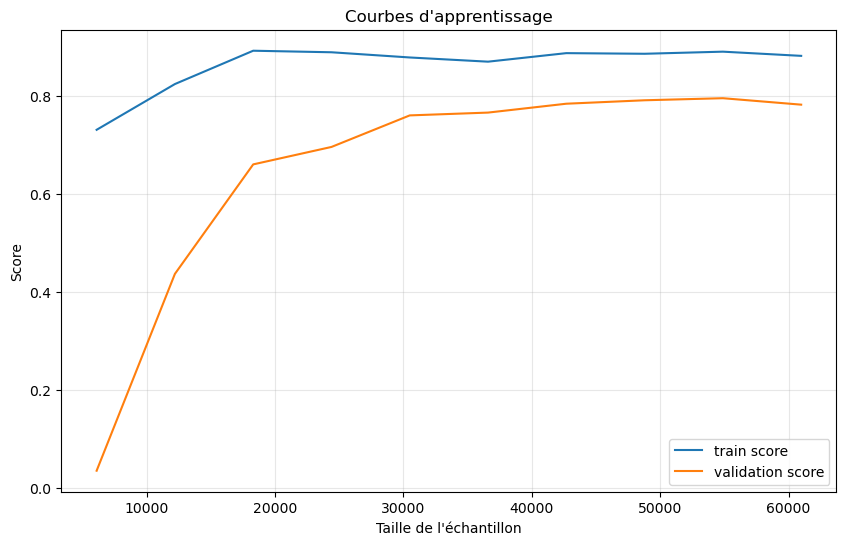

CPU times: total: 1min 50s
Wall time: 2min 6s


In [35]:
%%time
SVM = make_pipeline(preprocessor, StandardScaler(), SVC(random_state=0))
param_dist_svm = {
    "svc__C": [1],   # régularisation
    "svc__gamma": [0.1],  # complexité du noyau RBF
    "svc__kernel":  ["rbf"],
    "svc__degree": [2]   # utile si kernel=poly
}
search = RandomizedSearchCV(
    estimator=SVM,   # ou AdaBoost, ou SVM, ou KNN
    param_distributions=param_dist_svm,  # changer selon modèle
    n_iter=50,
    cv=5,
    n_jobs=2,
    random_state=0,
    verbose=2
)

train_grid(search)

#### Above 30000 observations it seems like the validation score is on an upward trend. Consequently we increase the number of samples in the trainset
 

In [17]:
preprocessor = make_pipeline(PolynomialFeatures(2, include_bias=False), SelectKBest(f_classif, k=10))
SVM = make_pipeline(preprocessor, StandardScaler(), SVC(random_state=0))

In [9]:
SVM = make_pipeline(preprocessor, StandardScaler(), SVC(random_state=0))
param_dist_svm = {
    "svc__C": [0.1, 1, 10,15],   # régularisation
    "svc__gamma": ["scale", "auto", 0.1, 0.15],  # complexité du noyau RBF
    "svc__kernel": ["linear", "rbf"],
    "svc__degree": [1,2, 3]   # utile si kernel=poly
}
search = RandomizedSearchCV(
    estimator=SVM,   # ou AdaBoost, ou SVM, ou KNN
    param_distributions=param_dist_svm,  # changer selon modèle
    n_iter=30,
    cv=5,
    n_jobs=2,
    random_state=0,
    verbose=2
)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
{'svc__kernel': 'rbf', 'svc__gamma': 'scale', 'svc__degree': 2, 'svc__C': 15}
[[14317     4]
 [    3    26]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14321
           1       0.87      0.90      0.88        29

    accuracy                           1.00     14350
   macro avg       0.93      0.95      0.94     14350
weighted avg       1.00      1.00      1.00     14350



C:\Users\karel\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:108: RuntimeWarning: invalid value encountered in divide
  msb = ssbn / float(dfbn)
C:\Users\karel\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\karel\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\karel\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **k

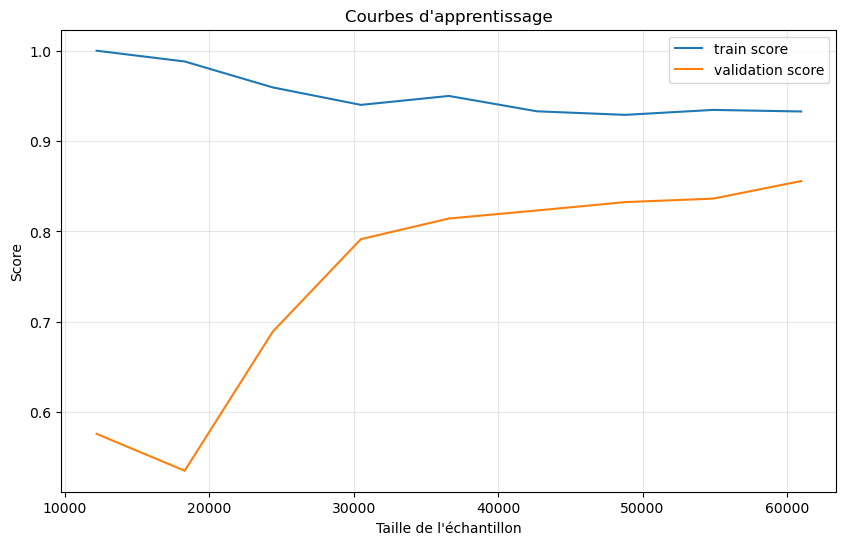

In [16]:
train_grid(search)

Fortunately it was a good decision. The model performs better

## RandomForest Classifier 

{'n_estimators': 300, 'min_samples_split': 18, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 15, 'criterion': 'entropy', 'bootstrap': False}
[[17181     4]
 [    4    31]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17185
           1       0.89      0.89      0.89        35

    accuracy                           1.00     17220
   macro avg       0.94      0.94      0.94     17220
weighted avg       1.00      1.00      1.00     17220



C:\Users\karel\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\karel\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\karel\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\karel\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "C:\Users\karel\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 89, in _

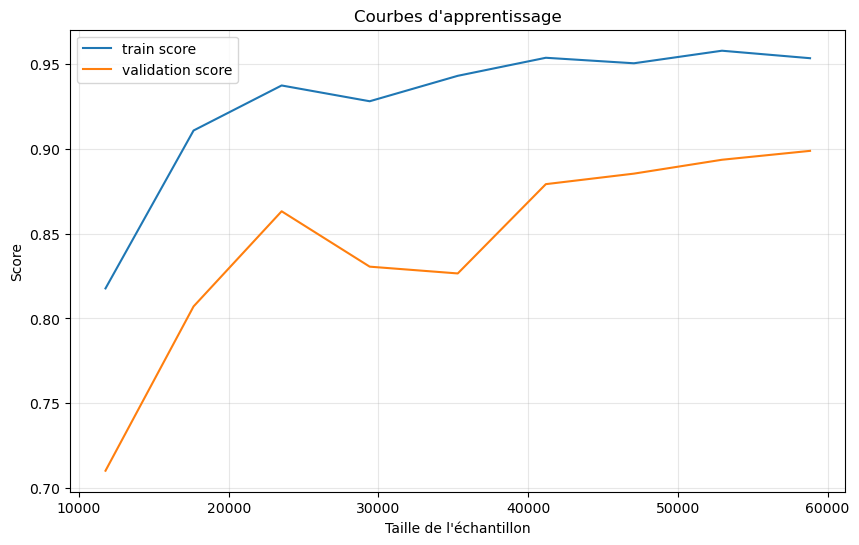

{'n_estimators': 300, 'min_samples_split': 18, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 15, 'criterion': 'entropy', 'bootstrap': False}
CPU times: total: 21min 46s
Wall time: 2h 46min 40s


In [44]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
import numpy as np

# Modèle
#rf = RandomForestClassifier(random_state=0)

# Espace de recherche
param_dist = {
    "n_estimators": [300],
    "max_depth": [None] + list(np.arange(5, 30, 5)),
    "min_samples_split": np.arange(2, 20, 2),
    "min_samples_leaf": np.arange(1, 20, 2),
    "max_features": [ None],
    "bootstrap": [False],
    "criterion": ["gini", "entropy", "log_loss"],
}

# RandomizedSearchCV
grid_rnd = RandomizedSearchCV(
    estimator=model_1,
    param_distributions=param_dist,
    n_iter=50,
    scoring='recall',
    cv=5,
    verbose=0,        # on coupe le verbose sklearn
    random_state=0,
    n_jobs=2
)

train_grid(grid_rnd)
print(grid_rnd.best_params_)

# ce qui est au niveau de scoring, c'est le paramètre qu'on veut optimiser recall permet de diminuer les faux négatifs
#au niveau de classification, report veuillez à passer le test avant le pred 

#### We can see on the previous graph that above 40000 samples, the validation score is an increasing function of the number of samples in the train set. Therefore, we increase the training set size and decrease the test set size.

## Best F1 score

{'n_estimators': 700, 'min_samples_split': 18, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 25, 'criterion': 'entropy', 'bootstrap': False}
[[14320     1]
 [    0    29]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14321
           1       0.97      1.00      0.98        29

    accuracy                           1.00     14350
   macro avg       0.98      1.00      0.99     14350
weighted avg       1.00      1.00      1.00     14350



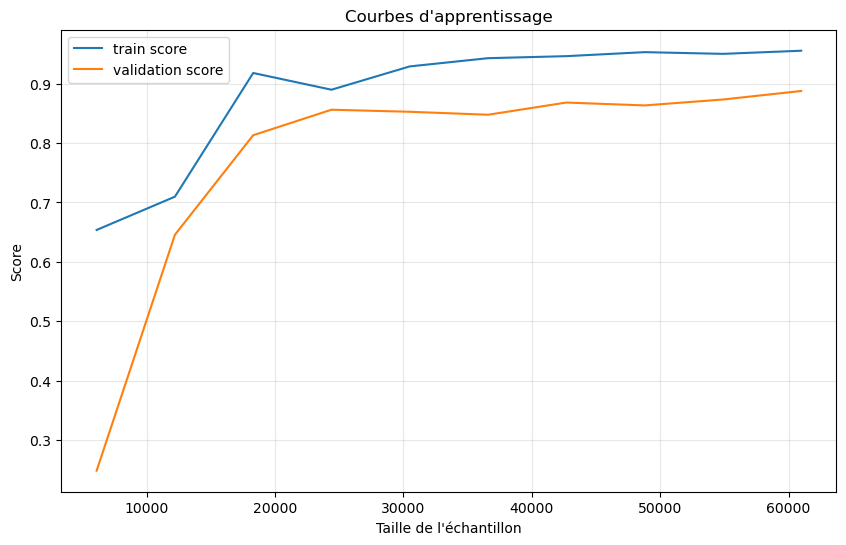

CPU times: total: 42min 45s
Wall time: 2h 43min 38s


In [22]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
import numpy as np

# Modèle
model_1 = RandomForestClassifier(random_state=0)

# Espace de recherche
param_dist = {
    "n_estimators": np.arange(100, 1001, 100),
    "max_depth": [None] + list(np.arange(5, 30, 5)),
    "min_samples_split": np.arange(2, 20, 2),
    "min_samples_leaf": np.arange(1, 20, 2),
    "max_features": ["sqrt", "log2", None],
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy", "log_loss"],
}

# RandomizedSearchCV
grid_rnd = RandomizedSearchCV(
    estimator=model_1,
    param_distributions=param_dist,
    n_iter=50,
    scoring='recall',
    cv=5,
    verbose=0,        # on coupe le verbose sklearn
    random_state=0,
    n_jobs=2
)


train_grid(grid_rnd)

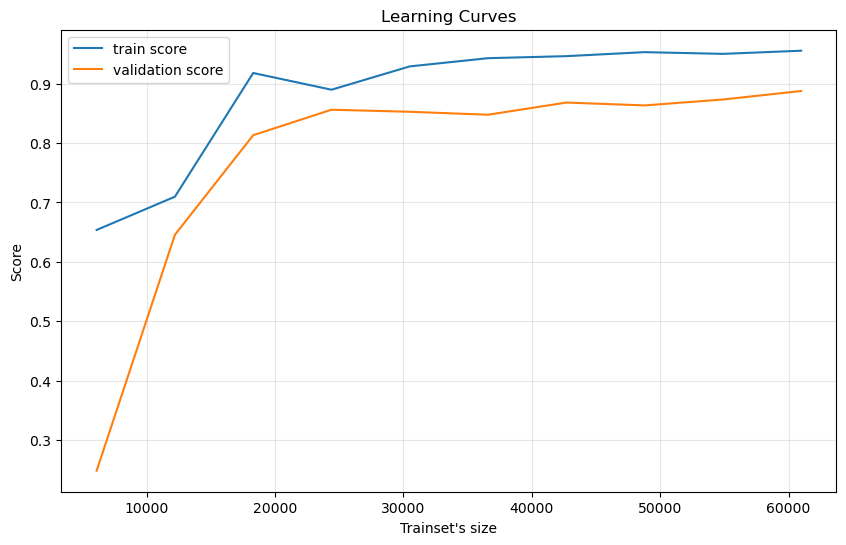

In [38]:
cv=StratifiedKFold(4)
N, train_score, val_score = learning_curve(grid_rnd.best_estimator_, x_train_trans, y_train,
                                              cv=cv, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
plt.figure(figsize=(10, 6))
plt.plot(N, train_score.mean(axis=1), label='train score')
plt.plot(N, val_score.mean(axis=1), label='validation score')
plt.xlabel('Trainset\'s size')
plt.ylabel('Score')
plt.title('Learning Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

C:\Users\karel\AppData\Local\Temp\ipykernel_24636\208967322.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


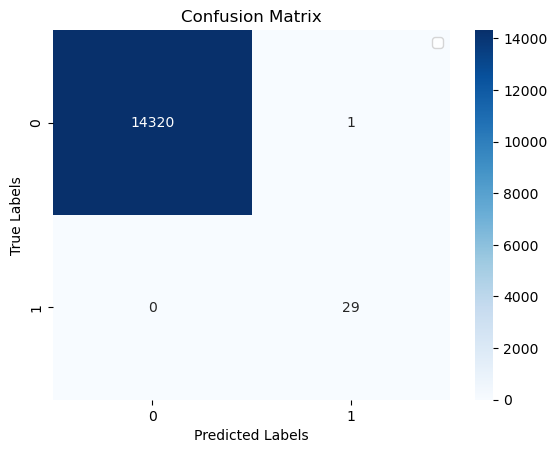

In [37]:
ypred = grid_rnd.best_estimator_.predict(x_test_trans)
import seaborn as sns
sns.heatmap(confusion_matrix(y_test,ypred), 
           annot=True,        # affiche les valeurs dans les cellules
           cmap='Blues',      # palette de couleurs
           fmt='d',           # format des nombres (entiers)
           cbar=True)         # barre de couleur
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.legend()
plt.show()


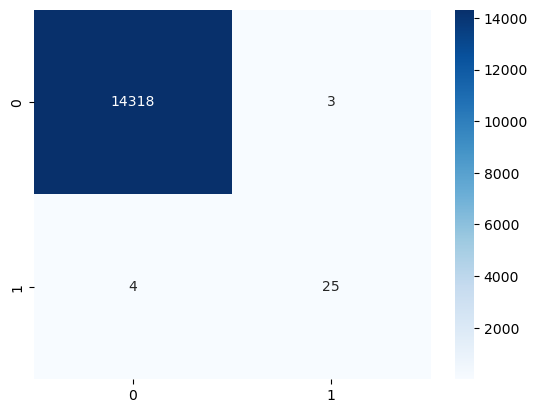

CPU times: total: 5min 9s
Wall time: 2h 11min 31s


In [7]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
import numpy as np

# Modèle
model_1 = RandomForestClassifier(random_state=0)

# Espace de recherche
param_dist = {
    "n_estimators": np.arange(100, 1001, 100),
    "max_depth": [None] + list(np.arange(5, 30, 5)),
    "min_samples_split": np.arange(2, 20, 2),
    "min_samples_leaf": np.arange(1, 20, 2),
    "max_features": ["sqrt", "log2", None],
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy", "log_loss"],
}

# RandomizedSearchCV
grid_rnd = RandomizedSearchCV(
    estimator=model_1,
    param_distributions=param_dist,
    n_iter=50,
    scoring='recall',
    cv=5,
    verbose=0,        # on coupe le verbose sklearn
    random_state=0,
    n_jobs=2
)



grid_rnd.fit(x_train_trans, y_train)
ypred = grid_rnd.best_estimator_.predict(x_test_trans)
import seaborn as sns
sns.heatmap(confusion_matrix(y_test,ypred), 
           annot=True,        # affiche les valeurs dans les cellules
           cmap='Blues',      # palette de couleurs
           fmt='d',           # format des nombres (entiers)
           cbar=True)         # barre de couleur
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.legend()
plt.show()


Endeed! We have a better performance. Well done 

In [13]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
import numpy as np

# Modèle
model_1 = RandomForestClassifier(random_state=0)

# Espace de recherche
param_dist = {
    "n_estimators": np.arange(100, 1001, 100),
    "max_depth": [None] + list(np.arange(5, 30, 5)),
    "min_samples_split": np.arange(2, 20, 2),
    "min_samples_leaf": np.arange(1, 20, 2),
    "max_features": ["sqrt", "log2", None],
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy", "log_loss"],
}

# RandomizedSearchCV
grid_rnd = RandomizedSearchCV(
    estimator=model_1,
    param_distributions=param_dist,
    n_iter=50,
    scoring='recall',
    cv=5,
    verbose=0,        # on coupe le verbose sklearn
    random_state=0,
    n_jobs=2
)

grid_rnd.fit(x_train_trans, y_train)
sns.heatmap(confusion_matrix(y_test, grid_rnd.best_params_.predict(x_test_trans)), 
           annot=True,        # affiche les valeurs dans les cellules
           cmap='Blues',      # palette de couleurs
           fmt='d',           # format des nombres (entiers)
           cbar=True)         # barre de couleur
plt.show()

KeyboardInterrupt: 

## XGBoost Classifier

Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\karel\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:45:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


{'subsample': 0.8, 'scale_pos_weight': 15, 'reg_lambda': 2, 'reg_alpha': 1, 'n_estimators': 400, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.9}


C:\Users\karel\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:45:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[[14309    12]
 [    6    23]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14321
           1       0.66      0.79      0.72        29

    accuracy                           1.00     14350
   macro avg       0.83      0.90      0.86     14350
weighted avg       1.00      1.00      1.00     14350



C:\Users\karel\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:45:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\karel\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:45:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\karel\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:45:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\karel\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:45:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr

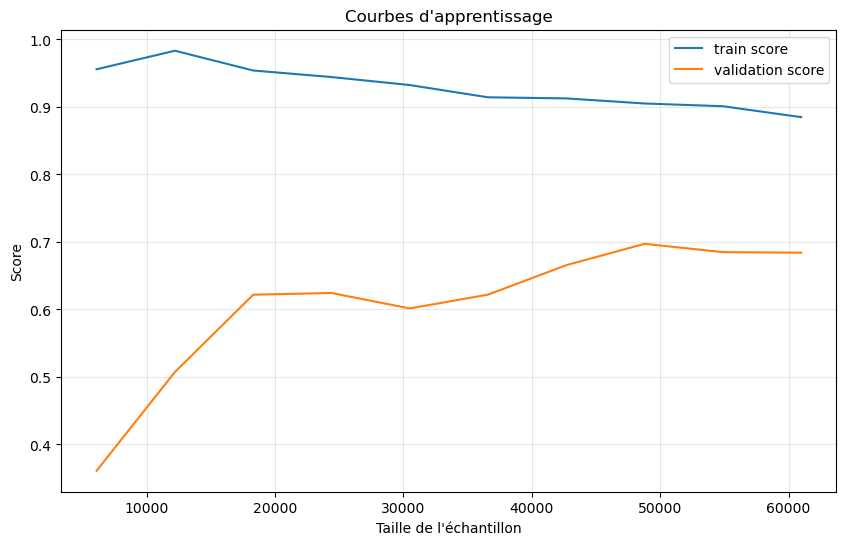

{'subsample': 0.8, 'scale_pos_weight': 15, 'reg_lambda': 2, 'reg_alpha': 1, 'n_estimators': 400, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.9}


TypeError: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

In [23]:
%%time
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss")

param_dist_xgb_improved = {
    "n_estimators": [200, 300, 400],  # Plus d'arbres
    "max_depth": [3, 4, 5],           # RÉDUIRE de 8 à max 5
    "learning_rate": [0.01, 0.05],    # RÉDUIRE de 0.1
    "subsample": [0.7, 0.8, 0.9],     # CHANGER de 1.0
    "colsample_bytree": [0.7, 0.8, 0.9],  # AJOUTER
    "reg_alpha": [0, 0.5, 1],         # AJOUTER régularisation L1
    "reg_lambda": [1, 2, 3],          # AJOUTER régularisation L2
    "scale_pos_weight": [10, 15, 20]  # AJOUTER pour déséquilibre
}

random_search_xgb = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist_xgb_improved,
    n_iter=30,
    scoring="f1",
    cv=3,
    random_state=42,
    verbose=1,
    n_jobs=2
)

train_grid(random_search_xgb)
print(random_search_xgb.best_params_)
best_model = random_search_xgb.best_estimator_

# Réentraîner avec early stopping
best_model.fit(
    x_train_trans, y_train,
    eval_set=[(x_train_trans, y_train), (x_test_trans, y_test)],
    early_stopping_rounds=20,
    verbose=True
)
ypred = best_model.predict(x_test_trans)
    
print(confusion_matrix(y_test, ypred))
print(classification_report(y_test, ypred))

## KNN

C:\Users\karel\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=50 is greater than n_features=20. All the features will be returned.
  warnings.warn(


{'pipeline__selectkbest__k': 50, 'pipeline__polynomialfeatures__degree': 1, 'kneighborsclassifier__weights': 'distance', 'kneighborsclassifier__n_neighbors': 5, 'kneighborsclassifier__metric': 'euclidean'}


C:\Users\karel\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=50 is greater than n_features=20. All the features will be returned.
  warnings.warn(


[[14321     0]
 [   13    16]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14321
           1       1.00      0.55      0.71        29

    accuracy                           1.00     14350
   macro avg       1.00      0.78      0.86     14350
weighted avg       1.00      1.00      1.00     14350



C:\Users\karel\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=50 is greater than n_features=20. All the features will be returned.
  warnings.warn(
C:\Users\karel\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=50 is greater than n_features=20. All the features will be returned.
  warnings.warn(
C:\Users\karel\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=50 is greater than n_features=20. All the features will be returned.
  warnings.warn(
C:\Users\karel\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=50 is greater than n_features=20. All the features will be returned.
  warnings.warn(
C:\Users\karel\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=50 is greater than n_features=20. All the features will be returned.
  warnings.warn(


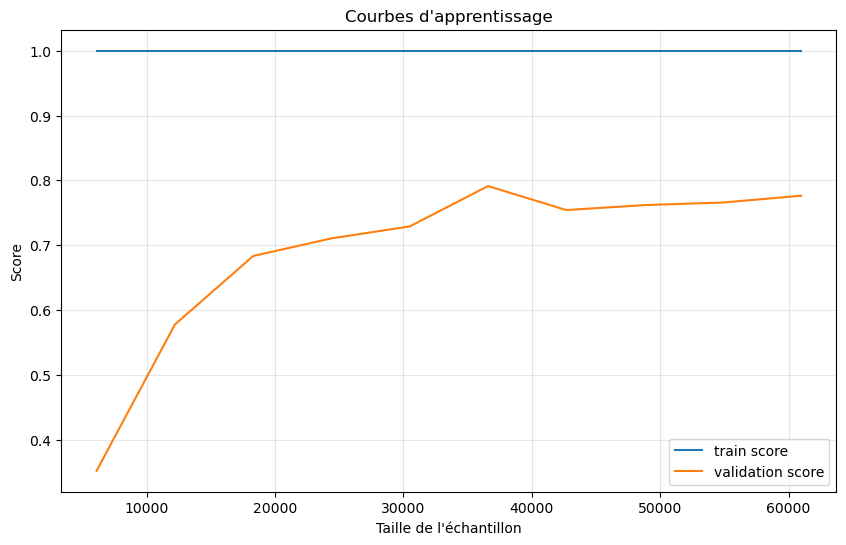

{'pipeline__selectkbest__k': 50, 'pipeline__polynomialfeatures__degree': 1, 'kneighborsclassifier__weights': 'distance', 'kneighborsclassifier__n_neighbors': 5, 'kneighborsclassifier__metric': 'euclidean'}


In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
KNN = make_pipeline(preprocessor, StandardScaler(), KNeighborsClassifier())
param_dist_knn = {
    'kneighborsclassifier__n_neighbors': np.arange(3, 21, 2),
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__metric': ['euclidean', 'manhattan'],
    
    # Pour vos autres étapes du pipeline:
    'pipeline__polynomialfeatures__degree': [1, 2],
    'pipeline__selectkbest__k': [50, 100, 200]
}

# Randomized Search (ici 10 itérations seulement pour rester léger)
random_search = RandomizedSearchCV(
    estimator=KNN,
    param_distributions=param_dist_knn,
    n_iter=30,
    cv=5,
    scoring="recall",      # ou "accuracy", "recall_macro" selon ton objectif
    random_state=42,
    n_jobs=2
)

# Entraînement
train_grid(random_search)
print(random_search.best_params_)

In [36]:
!pip install catboost
from catboost import CatBoostClassifier
cat_feature = ['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'ProviderId', 'ProductId',
       'ProductCategory', 'ChannelId',
        'PricingStrategy', 'IsWeekend','Month','DayOfWeek','WeekOfYear','Day','Hour','Crénaux_horaire']
cat_features_indices = [x_train.columns.get_loc(col) for col in cat_features]

# 8. Définir une recherche en grille pour optimiser quelques hyperparamètres de CatBoost
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [500, 1000],
}

# Initialiser le modèle CatBoost (sans affichage des logs)
model_cat = CatBoostClassifier(
    eval_metric='f1',
    random_seed=42,
    verbose=0,
    class_weights=[1, 10]
)

# Recherche en grille avec 5-fold CV
catboost = RandomizedSearchCV(
    estimator=model_cat,
    param_distributions=param_grid,
    scoring='f1',
    cv=5,
    verbose=2,
    n_jobs=2
)
catboost.fit(x_train,y_train,cat_features=cat_features_indices)
train_grid(catboost.best_estimator_,x_train,x_test)

^C
Fitting 5 folds for each of 10 candidates, totalling 50 fits



KeyboardInterrupt

